In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import minimize
# from gsl_implementation.gsl_wrapper import gamma_inc_array as gamma_inc
from mpmath import gammainc
from mpmath import erf
from slab import Slab
from sim_tools import Field3D, Field2D

In [ ]:
def gammainc_vec(a, x):
    result = []
    for i in range(x.size):
        result.append(float(gammainc(a[i], x[i])))
        
    return np.array(result)

def erf_vec(x):
    result = []
    for i in range(x.size):
        result.append(float(erf(x[i])))
        
    return np.array(result)

In [35]:
dens_512 = fits.open("/Users/elyasfarah/Documents/Galaxy Bias/deltam.fits")
dens_512 = delta_m = pd.DataFrame(dens_512[1].data)
ix_matter = dens_512["ix"]
iy_matter = dens_512["iy"]
iz_matter = dens_512["iz"]
dens = dens_512["dens"]
delta_m_grid = Slab.delta_m_catalogue_to_grid(ix_matter= ix_matter, iy_matter=iy_matter, 
                                              iz_matter=iz_matter, delta_m=dens, resol=512)

In [36]:
dens_512.columns

Index(['ix', 'iy', 'iz', 'dens'], dtype='object')

In [4]:
class Halos:
    """
    :halo_df_filename: csv file with the halo data
    :L: The side of the slabs in Mpc/h
    :N_grid: The 2d grids 
    :MASS_CUTOFF_LOW: Low mass cut-off (only select halos above this mass) 
    :MASS_CUTOFF_HIGH: High mass cut-off (only select halos below this mass) 
    """
    def __init__(self, halo_df_filename, 
                         L=1000., 
                         N_grid=512, 
                         MASS_CUTOFF_LOW  = 1e+11, 
                         MASS_CUTOFF_HIGH = 1e+16):
        self.N = N_grid
        self.L = L
        l = (self.L + 1e-10) / N_grid
        halo_df = fits.open(halo_df_filename)        
        halo_df = pd.DataFrame(halo_df[1].data)
        
        select_mass = (halo_df['mass'] > MASS_CUTOFF_LOW) & (halo_df['mass'] < MASS_CUTOFF_HIGH)
        
        self.halo_mass = np.array(halo_df['mass'].values[select_mass])
        self.x_halo = np.array(halo_df['x'].values[select_mass])
        self.y_halo = np.array(halo_df['y'].values[select_mass])
        self.z_halo = np.array(halo_df['z'].values[select_mass])

        self.ix_halo = (self.x_halo / l).astype(int)
        self.iy_halo = (self.y_halo / l).astype(int)
        self.iz_halo = (self.z_halo / l).astype(int)
    
    def get_halo_counts(self, L_start, L_end, axis='z'):
        counts_2d = np.zeros((self.N,self.N))
        if(axis=='z'):
            select_slice = (self.z_halo > L_start) & (self.z_halo < L_end)
            index_select = np.array([self.ix_halo[select_slice], self.iy_halo[select_slice]]).T
        if(axis=='y'):
            select_slice = (self.y_halo > L_start) & (self.y_halo < L_end)
            index_select = np.array([self.ix_halo[select_slice], self.iz_halo[select_slice]]).T
        if(axis=='x'):
            select_slice = (self.x_halo > L_start) & (self.x_halo < L_end)
            index_select = np.array([self.iy_halo[select_slice], self.iz_halo[select_slice]]).T
        unique_indices, counts = np.unique(index_select, axis=0, return_counts=True)
        counts_2d[unique_indices[:,0], unique_indices[:,1]] = counts
        return counts_2d
    
    def get_halo_counts_in_slabs(self, slab_width, axis='z'):
        # Extract eight 2d density slabs from the 3d density
        halo_count_list = []

        N_slabs = int(self.L / slab_width)
        for i in range(N_slabs):
            L_START = i * slab_width
            L_END   = (i+1) * slab_width
    
            halo_counts = self.get_halo_counts(L_START, L_END, axis)
            halo_count_list.append(halo_counts)        
        return halo_count_list

In [5]:
L      = 1000.

# Define the width of the slabs

slab_width = 125.

In [6]:
def rebin(a, N):
    sh = (N,a.shape[0]//N,
          N,a.shape[1]//N,
          N,a.shape[2]//N)

    b = a.reshape(sh)        
    return a.reshape(sh).mean(-1).mean(-2).mean(-3)

dens_256 = rebin(delta_m_grid, 256)
halo_df_filename = "/Users/elyasfarah/Documents/Galaxy Bias/halos.fits"

field_3d = Field3D(dens_256, L=L)
halos_256    = Halos(halo_df_filename, L, 256, MASS_CUTOFF_HIGH=10**16, MASS_CUTOFF_LOW=1e12)

Computing tidal fields...


In [10]:
# Extract eight 2d density slabs from the 3d density

delta_2d_list = field_3d.get_all_delta_slabs(slab_width)

In [8]:
del dens_256, delta_m_grid, dens_512


In [11]:
delta_2d_arr = np.array(delta_2d_list)
ncells = 8*4096
delta_m_vec = np.sort(delta_2d_arr.flatten())
delta_m_2D_bins = delta_m_vec.reshape(-1,ncells)

delta_m_bin_edges1 = np.zeros(delta_m_2D_bins.shape[0] + 1)
delta_m_bin_edges1[0] = np.min(delta_m_2D_bins, axis=1)[0]
delta_m_bin_edges1[-1] = np.max(delta_m_2D_bins, axis=1)[-1]
delta_m_bin_edges1[1:-1] = (np.max(delta_m_2D_bins, axis=1)[:-1] + np.min(delta_m_2D_bins, axis=1)[1:])/2

In [12]:
# splitting the last bin into more bins
ncells2 = 4*2048
delta_m_last_bin = delta_m_2D_bins[-1].reshape(-1, ncells2)
delta_m_bin_edges2 = np.zeros(delta_m_last_bin.shape[0] + 1)
delta_m_bin_edges2[0] = np.min(delta_m_last_bin, axis=1)[0]
delta_m_bin_edges2[-1] = np.max(delta_m_last_bin, axis=1)[-1]
delta_m_bin_edges2[1:-1] = (np.max(delta_m_last_bin, axis=1)[:-1] + np.min(delta_m_last_bin, axis=1)[1:])/2

In [13]:
delta_bins = np.concatenate([delta_m_bin_edges1[:-2], delta_m_bin_edges2])

In [14]:
mass_bins = np.logspace(12, 16,50)
mass_bin_centre = np.sqrt(mass_bins[1:] * mass_bins[:-1])

In [15]:
slab_id = (halos_256.z_halo // slab_width).astype(int)


In [16]:
nM_list = []

delta_mean_list = []
halos = halos_256
for i in range(len(delta_bins) - 1):
    delta_halo = delta_2d_arr[slab_id,halos.ix_halo, halos.iy_halo] #TAKING THE VOXELS THAT HAVE HALOS
    select_halo_delta = (delta_halo > delta_bins[i]) & (delta_halo < delta_bins[i+1]) # TAKING THE VOXELS IN A PARTICULAR DELTA_M BIN
    select_halo_mass  = halos.halo_mass[select_halo_delta] # MASKING OUT THE HALOS WHICH DO NOT EXIST IN THE CORRESPONDING DELTA_M BIN
    select_delta_bin = (delta_2d_arr > delta_bins[i]) & (delta_2d_arr < delta_bins[i+1]) # TAKING THE VOXELS IN A PARTICULAR DELTA_M BIN # MASKING OUT VOXELS OUTSIDE THE CHOSEN DELTA_M BIN
    delta_mean = delta_2d_arr[select_delta_bin].mean() # MASKING OUT VOXELS OUTSIDE THE CHOSEN DELTA_M BIN # THE MEAN DELTA_M OF THE SELECTED VOXELS
    delta_mean_list.append(delta_mean)
    
    N_pix = select_delta_bin.sum() # FIND THE NUMBER OF PIXELS IN THAT PARTICULr mass bin
    nV = select_halo_delta.sum() / N_pix # FIND THE AVERAGE NUMBER OF HALOS IN A VOXEL 
    
    pM, _ = np.histogram(select_halo_mass, mass_bins, density=True) # FIND THE WEIGHTED DISTRIBUTION OF HALO MASS IN EACH BIN
    nM_list.append(pM * nV) # FIND THE FRACTION OF HALOS IN EACH MASS BIN

In [17]:
def schechter_function(M, log10_ns,  alpha, log10_M0, beta, log10_ng, log10_Mg, log10_sigma, with_terms = False):    
    M0 = 10**log10_M0
    ns = 10**log10_ns
    ng = 10**log10_ng
    sigma = 10**log10_sigma
    Mg  = 10**log10_Mg
    term1  = ns * (M / M0)**alpha * np.exp(-(M/M0)**beta) 
    term2 =  (ng/M)*np.exp(-(np.log(M/Mg))**2/(2*sigma**2))
    term2 = 0
    if with_terms:
        return term1 + term2, term1, term2
    else:
        return term1 + term2

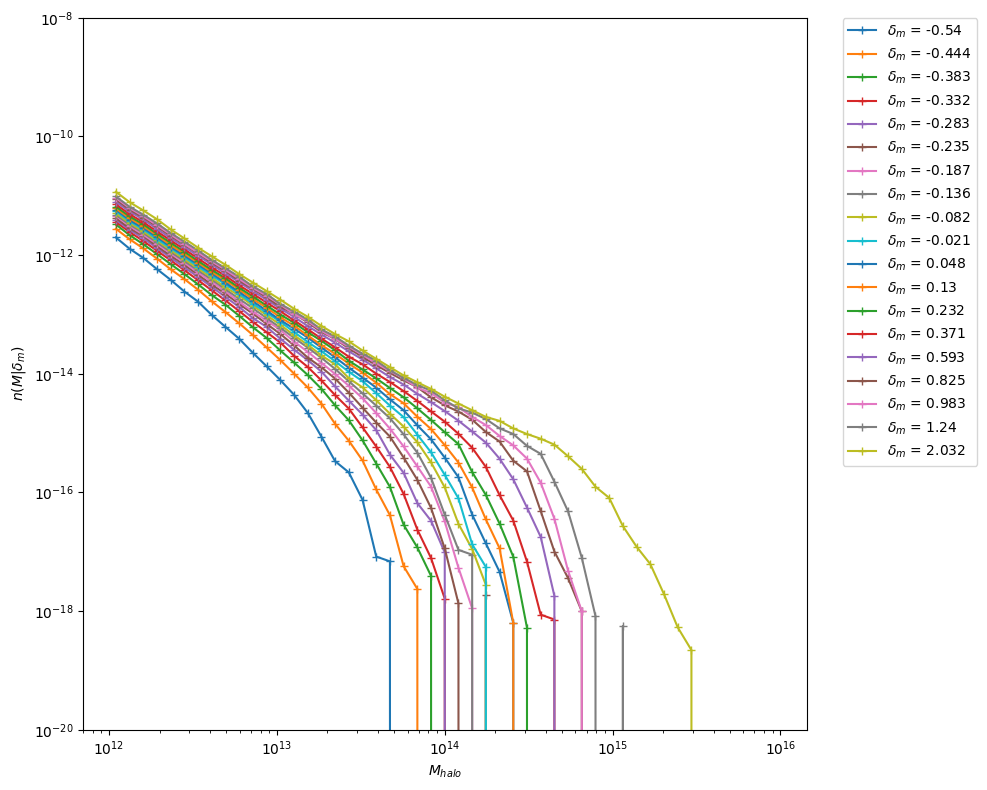

In [18]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.ylim(1e-20, 1e-8)
for i in range(len(nM_list)):
   
    plt.plot(mass_bin_centre, nM_list[i],  marker = '+', label = rf'$\delta_m$ = {np.round(delta_mean_list[i], 3)}')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$M_{halo}$")
plt.ylabel(r"$n(M|\delta_{m})$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

fig.savefig('halo_mass_data.png')

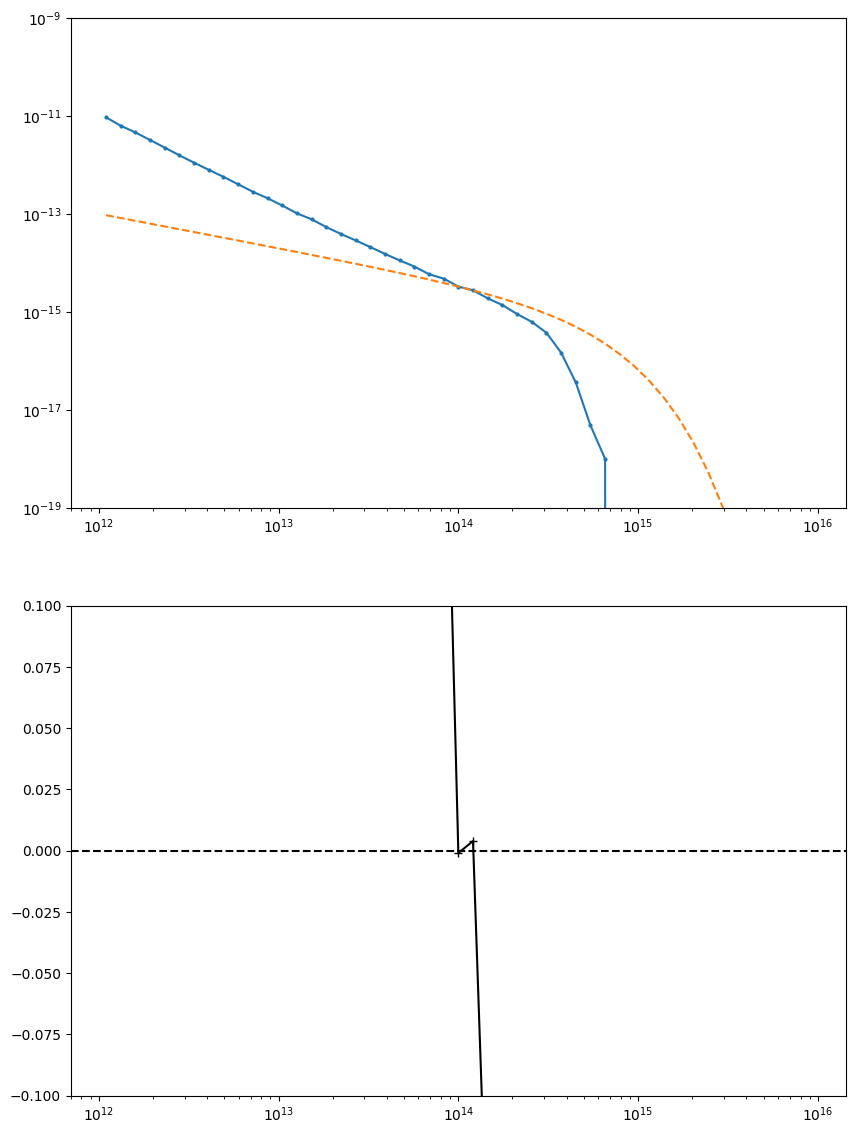

In [34]:
'''The slope in logarithmic space is constant then regularly increasing for bins with lower delta_m. 
The slope in logarihtmic space is constant increases a bit, then starts decreasing.'''

fig, (ax, ax_err) = plt.subplots(2, 1, figsize = (10, 14))
# trial and error
i = -3
ax.loglog(mass_bin_centre, nM_list[i], marker = "o", ms = 2)
nM_schechter, term1, term2 = schechter_function(M = mass_bin_centre, log10_ns = -14.85,  alpha = -0.7, log10_M0 = 14.64,  beta = 1.1, log10_ng = -0.48343039, log10_Mg = 14.,  log10_sigma = -0.19, with_terms=True)
nM_schechter2, term1, term2 = schechter_function(M = mass_bin_centre, log10_ns = -14.85,  alpha = -1.9, log10_M0 = 14.64,  beta = 1.1, log10_ng = -0.48343039, log10_Mg = 14.,  log10_sigma = -0.19, with_terms=True)


ax.loglog(mass_bin_centre, nM_schechter, ls = "dashed")
# ax.loglog(mass_bin_centre, term1, ls = "dashed", color = "green")
# ax.loglog(mass_bin_centre, term2, ls = "dashed", color = "red")
# ax.loglog(mass_bin_centre, nM_list[i] - term2, ls = "dashed", color = "k")

ax.set_ylim(1e-19, 1e-9)


ax_err.plot(mass_bin_centre, (nM_list[i] - nM_schechter)/nM_schechter, color = 'black', marker = "+")
ax_err.set_xscale('log')
ax_err.set_ylim(-0.1, 0.1)
ax_err.axhline(0, ls = "dashed", color = "k")    


/var/folders/pt/29l2vk0s1cd48zjgzrm1zvr80000gn/T/ipykernel_25051/1881579150.py:2: RuntimeWarning: divide by zero encountered in log10
  slope = (np.log10(nM_list[i][1:]) - np.log10(nM_list[i][:-1])) / (np.log10(mass_bin_centre[1:]) - np.log10(mass_bin_centre[:-1]))
/var/folders/pt/29l2vk0s1cd48zjgzrm1zvr80000gn/T/ipykernel_25051/1881579150.py:2: RuntimeWarning: invalid value encountered in subtract
  slope = (np.log10(nM_list[i][1:]) - np.log10(nM_list[i][:-1])) / (np.log10(mass_bin_centre[1:]) - np.log10(mass_bin_centre[:-1]))


(1000000000000.0, 1e+16)

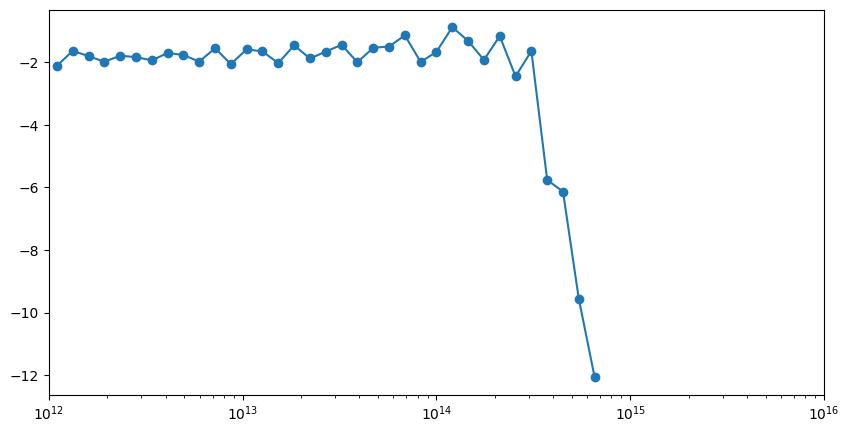

In [32]:
i = -2
slope = (np.log10(nM_list[i][1:]) - np.log10(nM_list[i][:-1])) / (np.log10(mass_bin_centre[1:]) - np.log10(mass_bin_centre[:-1]))
fig, (ax) = plt.subplots(1, 1, figsize = (10, 5))

plt.plot(mass_bin_centre[:-1], slope, marker = "o")
plt.xscale('log')
plt.xlim(1e12, 1e16)

In [60]:
def nh(log10_Mmin, log10_Mmax, *params):
    log10_M0, log10_ns, alpha, beta, log10_ng, log10_Mg, log10_sigma = params
    
    
    
    
    
    
    log10_min = log10_Mmin - log10_M0
    log10_max = log10_Mmax - log10_M0
    
    Gamma_min = gammainc((alpha + 1)/beta, (10**log10_min)**beta)
    Gamma_max = gammainc((alpha + 1)/beta, (10**log10_max)**beta)
    term1 = (10**log10_ns)*(10**log10_M0)*(1/beta)* (Gamma_min - Gamma_max)
    
    sigma = 10**log10_sigma
    log10_min = log10_Mmin - log10_Mg
    log10_max = log10_Mmax - log10_Mg
    
    prefactor = np.log10(np.sqrt(np.pi/2)) + log10_sigma + log10_ng
    term2 = (10**prefactor)*(erf((np.log(10) * log10_max)/(np.sqrt(2) * sigma)) - \
        erf((np.log(10) * log10_min)/(np.sqrt(2) * sigma)))
    term2 = 0
    return term1 + term2

def minus_Likelihood(delta_2d_arr, halo_cat, delta_m_min, delta_m_max, log10_Mmin, log10_Mmax, slab_width = 125, *params):
    log10_ns, alpha, log10_M0,  beta, log10_ng, log10_Mg, log10_sigma = params
    

    
    # print("params loaded")
    slab_id = (halo_cat.z_halo // slab_width).astype(int)
    # print("slabs are splite")
    
    
    delta_halo = delta_2d_arr[slab_id, halo_cat.ix_halo, halo_cat.iy_halo]
    # print("found the delta_m")   
    delta_halo_mask = np.where((delta_halo > delta_m_min) & (delta_halo < delta_m_max))
    delta_m_mask_size = np.where((delta_2d_arr.flatten() > delta_m_min) & (delta_2d_arr.flatten() < delta_m_max))[0].size
    # print("masked the halos")
    
    halo_mass_masked = halo_cat.halo_mass[delta_halo_mask]
    
    
    # print("calculated sibtraction")
    term1 = np.log(schechter_function(halo_mass_masked, log10_ns, alpha, log10_M0, beta, log10_ng, log10_Mg, log10_sigma))
    # print("term1 calculated")
    
    term2 = nh(log10_Mmin, log10_Mmax, log10_M0, log10_ns, alpha, beta, log10_ng, log10_Mg, log10_sigma)
    # print("term2 calculated")
    
    output = -1*(np.sum(term1) - (delta_m_mask_size*term2))
    return output

In [17]:
class Bounds:
    def __init__(self, ns, alpha, M0, beta, ng, Mg, sigma):
        self.log10_ns = ns
        self.alpha = alpha
        self.log10_M0 = M0
        self.beta = beta
        self.log10_ng = ng
        self.log10_Mg = Mg
        self.log10_sigma = sigma
    
    def get_bounds(self):
        return [self.log10_ns, self.alpha, self.log10_M0,  self.beta, self.log10_ng, self.log10_Mg, self.log10_sigma]
    
    def change_bounds_to_params(self, parameters):
        another_round = False
        for i in range(parameters.size):
            param_name = list(vars(self).keys())[i]
            
            param_bound =  vars(self)[param_name]
            
            if parameters[i] <= param_bound[0]:
                if param_name == 'log10_sigma':
                    new_bounds = (param_bound[0] - 0.20, param_bound[1] - 0.20)
                elif param_name == "beta":
                    new_bounds = (param_bound[0] - 0.20, param_bound[1] - 0.20)
                elif param_name == "alpha":
                    new_bounds = (param_bound[0] - 0.20, param_bound[1] - 0.20)     
                else:
                    new_bounds = (param_bound[0] - 1.0, param_bound[1] - 1.0)
                setattr(self, param_name, new_bounds)
                another_round = True
            elif parameters[i] >= param_bound[1]:
                if param_name == 'log10_sigma':
                    new_bounds = (param_bound[0] + 0.20, param_bound[1] + 0.20)
                elif param_name == 'beta':
                    new_bounds = (param_bound[0] + 0.20, param_bound[1] + 0.20)
                elif param_name == 'alpha':
                    new_bounds = (param_bound[0] + 0.20, param_bound[1] + 0.20)    
                else:
                    new_bounds = (param_bound[0] + 1.0, param_bound[1] + 1.0)
                setattr(self, param_name, new_bounds)
                another_round = True
        return another_round
    
    def get_lower_bounds(self):
        bounds = self.get_bounds()
        lower_bounds = np.min(bounds, axis = 1) + 0.05
        return  lower_bounds

In [162]:
bounds = Bounds((-17.3, -16.3),  (-1.9, -1.6),  (15., 16.),  (2.8, 3.2), (-1., 0.), (13.5, 14.5),  (-1, -0.1))

In [163]:
parameters = []
parameters_errors = []

In [164]:
from scipy.optimize import differential_evolution
for i in range(len(delta_mean_list)):
    round = 1
    index = len(delta_mean_list) - i -1
    while True:
        print('round', round, 'for bin', index)
        objective_function = lambda params: minus_Likelihood(delta_2d_arr, halos_256, delta_bins[index], delta_bins[index + 1], 12, 16, 125, *params)
        print(bounds.get_bounds(), bounds.get_lower_bounds())
        res = differential_evolution(objective_function, bounds = bounds.get_bounds(), x0 = bounds.get_lower_bounds() , seed = 42, maxiter=2500)
        change_bounds = bounds.change_bounds_to_params(res.x)
        if change_bounds:
            round = round + 1
            
        else:
            parameters.append(res.x)
            parameters_errors.append(res.population)
            print('bin', index, 'is completed within', round, 'rounds')
            print('===========')
            break

round 1 for bin 18
[(-17.3, -16.3), (-1.9, -1.6), (15.0, 16.0), (2.8, 3.2), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-17.25  -1.85  15.05   2.85  -0.95  13.55  -0.95]
round 2 for bin 18
[(-17.3, -16.3), (-1.9, -1.6), (15.0, 16.0), (3.0, 3.4000000000000004), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-17.25  -1.85  15.05   3.05  -0.95  13.55  -0.95]
round 3 for bin 18
[(-17.3, -16.3), (-1.9, -1.6), (15.0, 16.0), (3.2, 3.6000000000000005), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-17.25  -1.85  15.05   3.25  -0.95  13.55  -0.95]
bin 18 is completed within 3 rounds
round 1 for bin 17
[(-17.3, -16.3), (-1.9, -1.6), (15.0, 16.0), (3.2, 3.6000000000000005), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-17.25  -1.85  15.05   3.25  -0.95  13.55  -0.95]
bin 17 is completed within 1 rounds
round 1 for bin 16
[(-17.3, -16.3), (-1.9, -1.6), (15.0, 16.0), (3.2, 3.6000000000000005), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-17.25  -1.85  15.05   3.25  -0.95  13.55  -0.95]
round 2 for bin 16
[(-17.3, -16.3), (-

/var/folders/pt/29l2vk0s1cd48zjgzrm1zvr80000gn/T/ipykernel_2587/506251126.py:46: RuntimeWarning: divide by zero encountered in log
  term1 = np.log(schechter_function(halo_mass_masked, log10_ns, alpha, log10_M0, beta, log10_ng, log10_Mg, log10_sigma))


bin 10 is completed within 4 rounds
round 1 for bin 9
[(-15.3, -14.3), (-1.9, -1.6), (13.0, 14.0), (2.1999999999999993, 2.5999999999999996), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-15.25  -1.85  13.05   2.25  -0.95  13.55  -0.95]
round 2 for bin 9
[(-15.3, -14.3), (-2.1, -1.8), (13.0, 14.0), (1.9999999999999993, 2.3999999999999995), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-15.25  -2.05  13.05   2.05  -0.95  13.55  -0.95]
bin 9 is completed within 2 rounds
round 1 for bin 8
[(-15.3, -14.3), (-2.1, -1.8), (13.0, 14.0), (1.9999999999999993, 2.3999999999999995), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-15.25  -2.05  13.05   2.05  -0.95  13.55  -0.95]
round 2 for bin 8
[(-15.3, -14.3), (-2.1, -1.8), (13.0, 14.0), (1.7999999999999994, 2.1999999999999993), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-15.25  -2.05  13.05   1.85  -0.95  13.55  -0.95]
round 3 for bin 8
[(-15.3, -14.3), (-2.1, -1.8), (13.0, 14.0), (1.5999999999999994, 1.9999999999999993), (-1.0, 0.0), (13.5, 14.5), (-1, -0.1)] [-15.

In [165]:
np.save('parameters_diff_evol_exp_only.npy', np.array(parameters))
np.save('parameters_diff_evol_exp_only_errors.npy', np.array(parameters_errors))


In [ ]:
'''parameters = np.flip(np.load('parameters_diff_evol_exp2.npy'), axis=0)
parameters_errors = np.flip(np.load('/Users/elyasfarah/Documents/Galaxy Bias/lib/parameters_errors_diff_evol_exp2.npy'), axis=0)
std_parameters = np.std(parameters_errors, axis = 1)
parameters_lower = parameters -  std_parameters
parameters_higher = parameters +  std_parameters'''

In [18]:
color_list = ['r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b', 'r', 'b', 'g', 'c', 'm', 'orange', 'k', 'r', 'b', 'g', 'c', 'k', 'r', 'b', 'g', 'c','m', 'orange', 'k', 'r', 'b']

In [61]:
parameters = np.load('parameters_diff_evol_exp_only.npy')

In [86]:
import plothist

/var/folders/pt/29l2vk0s1cd48zjgzrm1zvr80000gn/T/ipykernel_32323/196750278.py:20: RuntimeWarning: invalid value encountered in divide
  ax_err.plot(mass_bin_centre, (nM_list[index]/nM_schechter) -1, color = color_list[i])


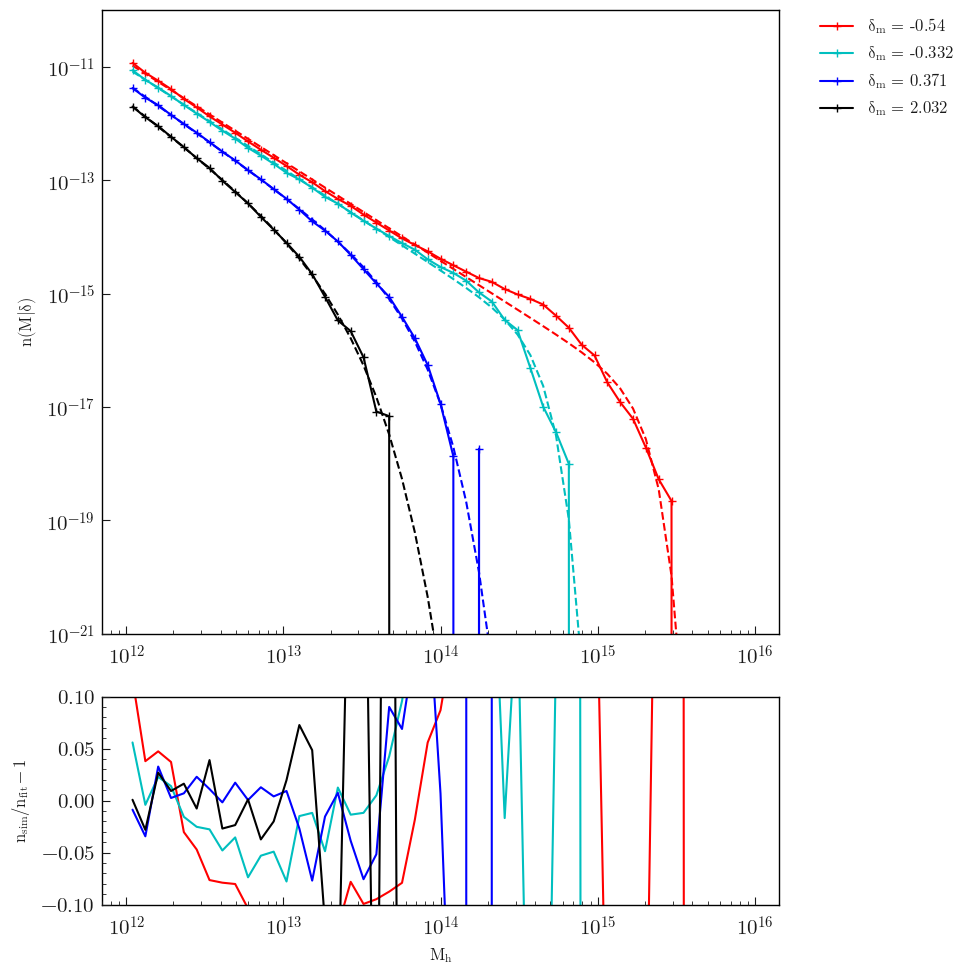

In [90]:
fig, (ax, ax_err) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [3, 1]},figsize = (10, 10))
for i in range(len(delta_mean_list)):
    
    index = len(delta_mean_list) - i -1
    if index != 0 and index != 5 and index != 15 and index != 18:
        continue
    log10_ns, alpha, log10_M0,  beta, log10_ng, log10_Mg, log10_sigma = parameters[i]

    ax.loglog(mass_bin_centre, nM_list[index], color = color_list[i], marker = "+", label = rf'$\delta_m$ = {np.round(delta_mean_list[i], 3)}')
    nM_schechter, term1, term2 = schechter_function(M = mass_bin_centre, log10_M0=log10_M0 , log10_ns=log10_ns, alpha=alpha, beta=beta, log10_ng=log10_ng, log10_Mg=log10_Mg, log10_sigma=log10_sigma, with_terms=True)
    # ax.loglog(mass_bin_centre, term1, color='b')
    # ax.loglog(mass_bin_centre, term2, '-.', color='b')
    ax.loglog(mass_bin_centre, nM_schechter, '--', color = color_list[i] )
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    # nM_schechter_lower = schechter_function(mass_bin_centre, *parameters_lower[i], with_terms=False)
    # nM_schechter_higher = schechter_function(mass_bin_centre, *parameters_higher[i], with_terms=False)
    # ax.fill_between(mass_bin_centre, nM_schechter_lower, nM_schechter_higher, color = color_list[i], alpha = 0.2)
    ax.set_ylim(1e-21, 1e-10)
    ax_err.plot(mass_bin_centre, (nM_list[index]/nM_schechter) -1, color = color_list[i])
    ax_err.set_xscale('log')
    ax_err.set_ylim(-0.1, 0.1)
    ax.set_ylabel(r'$n(M|\delta)$',fontsize = 12)
    ax_err.set_xlabel(r'$M_h$', fontsize = 12)
    ax_err.set_ylabel(r'$n_{sim}/n_{fit} - 1$', fontsize = 12)
# ax.set_xlim(1e12, 1e14)
plt.tight_layout()
fig.savefig('/Users/elyasfarah/Documents/Galaxy Bias/lib/figs_present/sch_log_exp.png', dpi = 300)

In [91]:
parameters.shape

(19, 7)

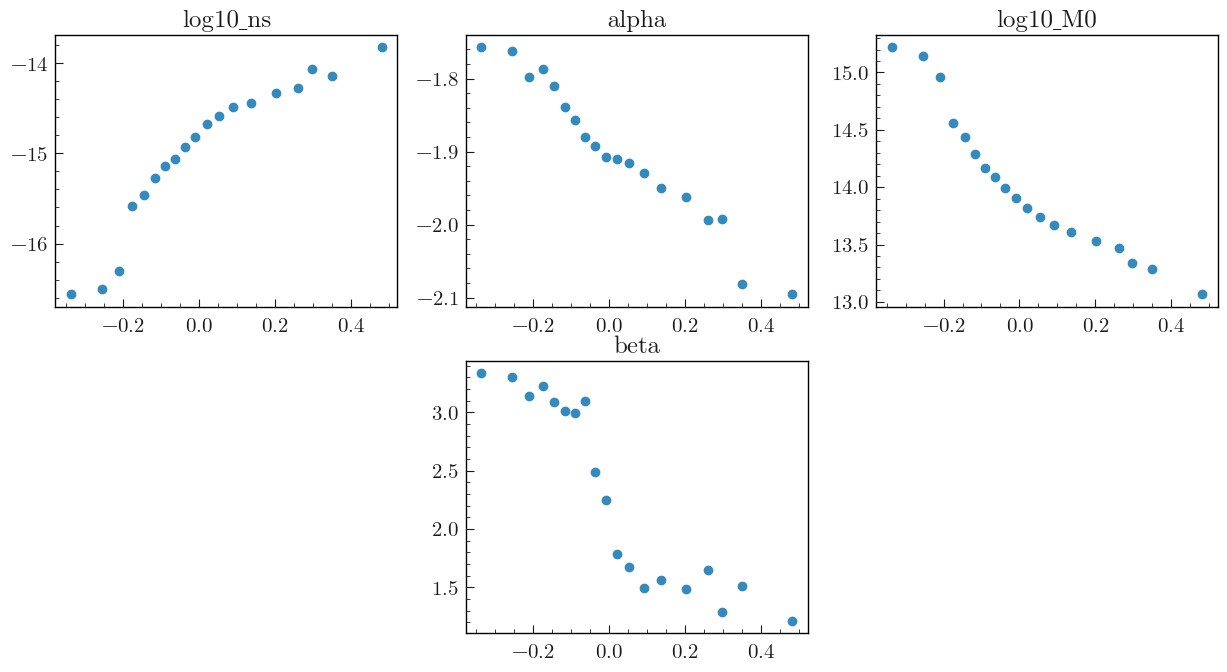

In [104]:
x = np.linspace(-1, 5)

log_delta = np.log10(1 + np.array(delta_mean_list))


fig = plt.figure(figsize=(15, 12))

# Top row - 3 panels
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1))
ax3 = plt.subplot2grid((3, 3), (0, 2))

# Middle row - 1 panel spanning all 3 columns
ax4 = plt.subplot2grid((3, 3), (1, 1), colspan=1)

# Bottom row - 3 panels
# ax5 = plt.subplot2grid((3, 3), (2, 0))
# ax6 = plt.subplot2grid((3, 3), (2, 1))
# ax7 = plt.subplot2grid((3, 3), (2, 2))










ax1.set_title('log10_ns')
ax1.scatter(log_delta, parameters[:, 0])

ax2.set_title('alpha')
ax2.scatter(log_delta, parameters[:, 1])

ax3.set_title('log10_M0')
ax3.scatter(log_delta, parameters[:, 2])

ax4.set_title('beta')
ax4.scatter(log_delta, parameters[:, 3])


# ax5.set_title('log10_ng')
# ax5.scatter(log_delta, parameters[:, 4])

# ax6.set_title('log10_Mg')
# ax6.scatter(log_delta, parameters[:, 5])

# ax7.set_title('log10_sigma')
# ax7.scatter(log_delta, parameters[:, 6])








In [105]:
fig.savefig('/Users/elyasfarah/Documents/Galaxy Bias/lib/figs_present/paramters_exp_log.png', bbox_inches='tight', dpi=300)

In [93]:
w = np.ones_like(log_delta)
w[-4:] = 0.25

In [97]:
from scipy.interpolate import UnivariateSpline

log10ns_interp = UnivariateSpline(y =parameters[:, 0], x = log_delta, k = 1, s = 2, ext = 0, w = w)


log10M0_interp = UnivariateSpline(y =parameters[:, 2], x = log_delta, k = 1, s = 1, ext = 0, w = w)


alpha_interp1 = UnivariateSpline(y = parameters[:, 1][:10], x = log_delta[:10], k = 1, s = 2, ext = 0, w = w[:10])
alpha_interp2 = UnivariateSpline(y = parameters[:, 1][10:], x = log_delta[10:], k = 1, s = 2, ext = 0, w = w[10:])

# alpha_interp = UnivariateSpline(y = parameters[:, 1], x = log_delta, k = 1, s = 2, ext = 0, w = w)



beta_interp = UnivariateSpline(y =parameters[:, 3], x = log_delta, k = 1, s = 2, ext = 0, w = w)


log10ng_interp = UnivariateSpline(y =parameters[:, 4][-5:], x = log_delta[-5:], k = 1, s = 2, ext = 0, w = w[-5:])


log10Mg_interp = UnivariateSpline(y =parameters[:, 5][-5:], x = log_delta[-5:], k = 1, s = 1, ext = 0, w = w[-5:])

# log10Mg_interp1 = UnivariateSpline(y =parameters[:, 5][:i], x = log_delta[:i], k = 1, s = 1, ext = 0, w = w[:i])
# log10Mg_interp2 = UnivariateSpline(y =parameters[:, 5][i:], x = log_delta[i:], k = 1, s = 1, ext = 0, w = w[i:])

log10sigma_interp = UnivariateSpline(y =parameters[:, 6][-5:], x = log_delta[-5:], k = 1, s = 1, ext = 0, w = w[-5:])

# log10sigma_interp1 = UnivariateSpline(y =parameters[:, 6][:i], x = log_delta[:i], k = 1, s = 2, ext = 0, w = w[:i])
# log10sigma_interp2 = UnivariateSpline(y =parameters[:, 6][i:], x = log_delta[i:], k = 1, s = 2, ext = 0, w = w[i:])



In [95]:
def alpha_interp(log_delta_m, log_delta_lim = log_delta[i]):
    result = np.zeros_like(log_delta_m)
    smaller = np.where(log_delta_m < log_delta_lim)
    larger = np.where(log_delta_m >= log_delta_lim)
    result[smaller[0]] = alpha_interp1(log_delta_m[smaller[0]])
    result[larger[0]] = alpha_interp2(log_delta_m[larger[0]])
    
    return result


'''def log10sigma_interp(log_delta_m, log_delta_lim = log_delta[i]):
    result = np.zeros_like(log_delta_m)
    smaller = np.where(log_delta_m < log_delta_lim)
    larger = np.where(log_delta_m >= log_delta_lim)
    result[smaller[0]] = log10sigma_interp1(log_delta_m[smaller[0]])
    result[larger[0]] = log10sigma_interp2(log_delta_m[larger[0]])
    
    return result'''


'''def log10Mg_interp(log_delta_m, log_delta_lim = log_delta[i]):
    result = np.zeros_like(log_delta_m)
    smaller = np.where(log_delta_m < log_delta_lim)
    larger = np.where(log_delta_m >= log_delta_lim)
    result[smaller[0]] = log10Mg_interp1(log_delta_m[smaller[0]])
    result[larger[0]] = log10Mg_interp2(log_delta_m[larger[0]])
    
    return result'''

'''def beta_interp(log_delta_m, log_delta_lim = log_delta[i]):
    result = np.zeros_like(log_delta_m)
    smaller = np.where(log_delta_m < log_delta_lim)
    larger = np.where(log_delta_m >= log_delta_lim)
    result[smaller[0]] = beta_interp1(log_delta_m[smaller[0]])
    result[larger[0]] = beta_interp2(log_delta_m[larger[0]])
    
    return result'''

'def beta_interp(log_delta_m, log_delta_lim = log_delta[i]):\n    result = np.zeros_like(log_delta_m)\n    smaller = np.where(log_delta_m < log_delta_lim)\n    larger = np.where(log_delta_m >= log_delta_lim)\n    result[smaller[0]] = beta_interp1(log_delta_m[smaller[0]])\n    result[larger[0]] = beta_interp2(log_delta_m[larger[0]])\n\n    return result'

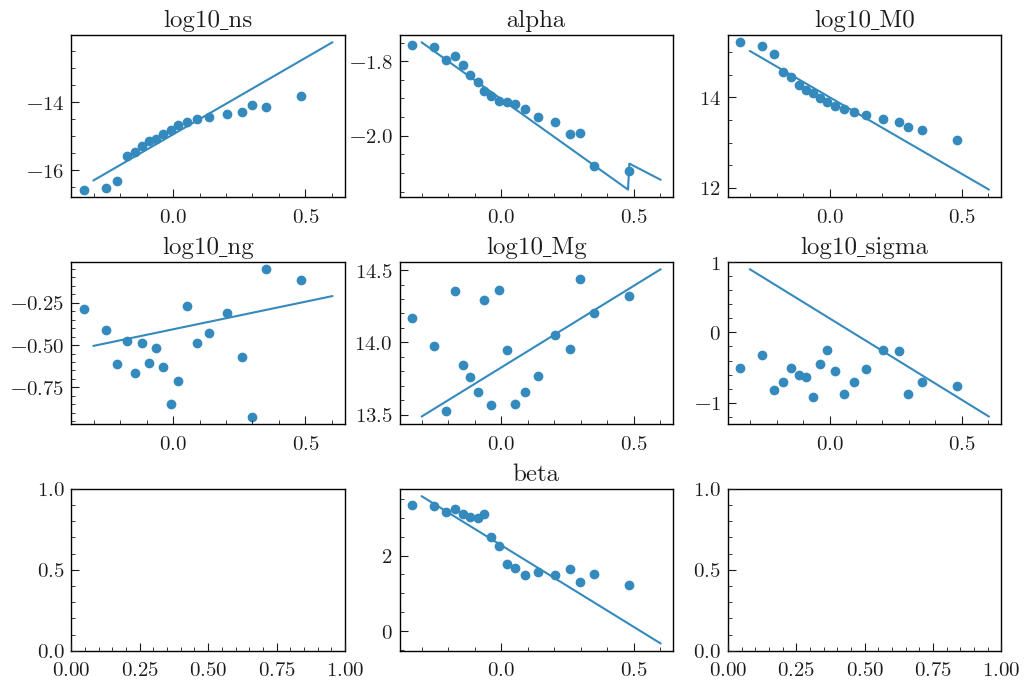

In [98]:
log_delta_m = np.log10(1 + np.linspace(-0.5, 3, 100))

fig, ax = plt.subplots(3, 3, figsize = (12, 8))
plt.subplots_adjust(hspace=0.4)  # Increase vertical space between rows

ax[0][0].set_title('log10_ns')
ax[0][0].scatter(log_delta, parameters[:, 0])
ax[0][0].plot(log_delta_m, log10ns_interp(log_delta_m))



ax[0][1].set_title('alpha')
ax[0][1].scatter(log_delta, parameters[:, 1])
ax[0][1].plot(log_delta_m, alpha_interp(log_delta_m))



ax[0][2].set_title('log10_M0')
ax[0][2].scatter(log_delta, parameters[:, 2])
ax[0][2].plot(log_delta_m,log10M0_interp(log_delta_m))



ax[1][0].set_title('log10_ng')
ax[1][0].scatter(log_delta, parameters[:, 4])
ax[1][0].plot(log_delta_m,log10ng_interp(log_delta_m))



ax[1][1].set_title('log10_Mg')
ax[1][1].scatter(log_delta, parameters[:, 5])
ax[1][1].plot(log_delta_m,log10Mg_interp(log_delta_m))



ax[1][2].set_title('log10_sigma')
ax[1][2].scatter(log_delta, parameters[:, 6])
ax[1][2].plot(log_delta_m,log10sigma_interp(log_delta_m))


ax[2][1].set_title('beta')
ax[2][1].scatter(log_delta, parameters[:, 3])
ax[2][1].plot(log_delta_m, beta_interp(log_delta_m))





In [99]:
M_min = 10**12
M_max = 10**15


M_halo_bin_edges = np.logspace(np.log10(M_min), np.log10(M_max), 6)

In [100]:
nh_list = []
delta_m = np.log10(1 + np.linspace(-0.9, 2.5, 100))
log_M_bin_edges = np.log10(M_halo_bin_edges)

In [ ]:
def nh(log10_one_delta_m, log10_Mmin, log10_Mmax, *funcs):
    log10_ns_func, alpha_func, log10_M0_func, beta_func = funcs
    
    log10_ns = log10_ns_func(log10_one_delta_m)
    alpha = alpha_func(log10_one_delta_m)
    log10_M0 = log10_M0_func(log10_one_delta_m)
    beta = beta_func(log10_one_delta_m)
    
    log10_min = log10_Mmin - log10_M0
    log10_max = log10_Mmax - log10_M0
    
    Gamma_min = gammainc_vec((alpha + 1)/beta, (10**log10_min)**beta)
    Gamma_max = gammainc_vec((alpha + 1)/beta, (10**log10_max)**beta)
    term1 = (10**log10_ns)*(10**log10_M0)*(1/beta)* (Gamma_min - Gamma_max)
    
    
    
   
    return term1

In [102]:
term1_list = []
term2_list = []

for i in range(log_M_bin_edges.size - 1): 
    value, term1, term2 = nh(log_delta_m, log_M_bin_edges[i], log_M_bin_edges[i + 1], log10ns_interp, alpha_interp, log10M0_interp, beta_interp, log10ng_interp, log10Mg_interp,  log10sigma_interp)
    nh_list.append(value)
    term1_list.append(term1)
    term2_list.append(term2)
    


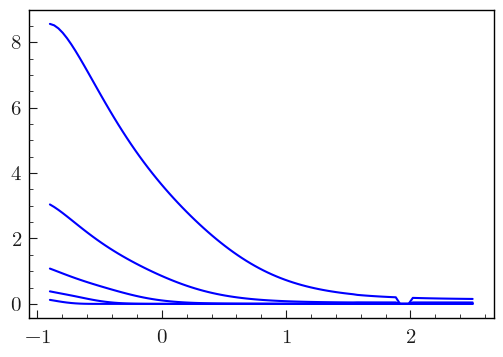

In [103]:
for i in range(log_M_bin_edges.size - 1):
    plt.plot(np.linspace(-0.9, 2.5, 100), nh_list[i], color = 'b')
    # plt.plot(np.linspace(-0.9, 2.5, 100), term1_list[i], color= 'r', ls = '--')
    # plt.plot(np.linspace(-0.9, 2.5, 100), term2_list[i], color='g')
# plt.yscale("log")


In [192]:
np.save("/Users/elyasfarah/Documents/Galaxy Bias/lib/nh_list_lower.npy", nh_list)